In [9]:
import os
import pickle
import random
import gymnasium as gym
import jax
import jax.numpy as jnp
import jax.nn as nn
import numpy as np
import optax
import matplotlib.pyplot as plt

from gymnasium import wrappers
from jax import value_and_grad, jit, Array, lax, tree_map
from flax import linen
from numpy.typing import NDArray
from typing import List

from utils.common import KeyGenerator, ReplayBuffer, Transition
%matplotlib inline 

/var/folders/zv/cn3g221n20z8gnl4x2nm3d280000gp/T/ipykernel_25919/2331400260.py:13: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  from jax import value_and_grad, jit, Array, lax, tree_map


In [10]:
class NeuralNet(linen.Module):
    hidden_size: int = 128
    action_space: int = 2 # discrete action space
    @linen.compact
    def __call__(self, x):
        x = linen.Dense(self.hidden_size, kernel_init=linen.initializers.xavier_normal())(x)
        x = linen.relu(x)
        x = linen.Dense(self.hidden_size, kernel_init=linen.initializers.xavier_normal())(x)
        x = linen.relu(x)
        action_values = linen.Dense(self.action_space, kernel_init=linen.initializers.xavier_normal())(x)
        return action_values

In [11]:
gamma = 0.99
seed = 0
lr = 1e-4
tau = 5e-2
num_envs = 10

random.seed(seed)
key_gen = KeyGenerator(seed)

venv = gym.make_vec('CartPole-v1', num_envs=num_envs)
obs_apace = venv.observation_space
action_space = venv.action_space
print('observation shape:', obs_apace.shape)
print('action shape:', action_space.shape)

neural_net = NeuralNet()
opt = optax.adam(lr)
obs, info = venv.reset(seed=seed)

# initialize the states
learner_params = neural_net.init(key_gen()[0], obs)
target_params = learner_params
opt_state = opt.init(learner_params)


@jit
def greedy_pol(params: dict,
               obs: NDArray):
    q_values = neural_net.apply(params, obs)
    return jnp.argmax(q_values, axis=1)


@jit
def random_pol(key: Array, obs: NDArray):
    return jax.random.randint(key=key,
                              shape=(obs.shape[0],),
                              minval=0,
                              maxval=2)

@jit
def policy(params: dict,
           obs: NDArray,
           key: Array,
           epsilon: float):

    def random_func(params, obs): return random_pol(key, obs)

    action = lax.cond(jax.random.bernoulli(key, epsilon),
                      random_func,
                      greedy_pol,
                      params,
                      obs)
    return action


def collect_transitions(obs: NDArray,
                        params: dict,
                        r_buffer: ReplayBuffer,
                        epsilon: float,
                        steps: int = 100):

    assert obs.shape[0] == num_envs

    for _ in range(steps):
        key = key_gen()[0]
        act = policy(params, obs, key, epsilon)
        next_obs, rew, terminated, truncated, info = venv.step(np.asarray(act))

        # flatten and process the transitions
        for env_idx in range(num_envs):
            if terminated[env_idx]:
                r_buffer.push(
                    obs[env_idx],
                    act[env_idx],
                    rew[env_idx],
                    info['final_observation'][env_idx],
                    1)
            elif truncated[env_idx]:
                r_buffer.push(
                    obs[env_idx],
                    act[env_idx],
                    rew[env_idx],
                    info['final_observation'][env_idx],
                    0)
            else:
                r_buffer.push(
                    obs[env_idx],
                    act[env_idx],
                    rew[env_idx],
                    next_obs[env_idx],
                    0)
        obs = next_obs

    return obs


def process_transitions(transition_list: List[Transition]):
    obs_batch = jnp.asarray([transition.obs for transition in transition_list])
    act_batch = jnp.asarray([transition.act for transition in transition_list])
    rew_batch = jnp.asarray([transition.rew for transition in transition_list])
    next_obs_batch = jnp.asarray(
        [transition.next_obs for transition in transition_list])
    done_batch = jnp.asarray(
        [transition.done for transition in transition_list])
    return obs_batch, act_batch, rew_batch, next_obs_batch, done_batch


def compute_loss(params: dict,
                 target_params: dict,
                 obs: NDArray,
                 act: NDArray,
                 rew: NDArray,
                 next_obs: NDArray,
                 done: NDArray):

    q_values = neural_net.apply(params, obs)
    next_q_values = neural_net.apply(target_params, next_obs)
    target_q_values = rew + gamma * jnp.max(next_q_values, axis=1) * (1 - done)
    tde = q_values[jnp.arange(len(q_values)), act] - target_q_values
    return jnp.mean(tde**2)


grad_fn = jit(value_and_grad(compute_loss))


@jit
def update_target(params: dict,
                  target_params: dict):
    return tree_map(lambda p, tp: tau * p + (1 - tau) * tp, params, target_params)


@jit
def update_learner(params: dict,
                   target_params: dict,
                   opt_state: dict,
                   batch: List[Transition]):

    loss, gradient = grad_fn(params,
                             target_params,
                             *process_transitions(batch))

    updates, next_opt_state = opt.update(gradient, opt_state)
    next_params = optax.apply_updates(params, updates)
    return next_params, next_opt_state, loss


def evaluate(params: dict,
             seed: int,
             num_eps=10):
    env_eval = gym.make('CartPole-v1')
    env_eval = wrappers.RecordEpisodeStatistics(env_eval)
    cum_rews = []
    for i in range(num_eps):
        obs, info = env_eval.reset(seed=seed+i)
        terminated, truncated = False, False
        while not terminated and not truncated:
            act = greedy_pol(params, obs[None])
            obs, rew, terminated, truncated, info = env_eval.step(np.asarray(act[0]))
        cum_rews.append(info['episode']['r'])
    env_eval.close()
    return np.mean(cum_rews)

observation shape: (10, 4)
action shape: (10,)


step: 10, mean return: 9.5
step: 20, mean return: 9.600000381469727
step: 30, mean return: 9.199999809265137
step: 40, mean return: 9.300000190734863
step: 50, mean return: 9.600000381469727
step: 60, mean return: 9.399999618530273
step: 70, mean return: 9.399999618530273
step: 80, mean return: 9.199999809265137
step: 90, mean return: 9.399999618530273
step: 100, mean return: 9.800000190734863
step: 110, mean return: 9.699999809265137
step: 120, mean return: 9.399999618530273
step: 130, mean return: 9.300000190734863
step: 140, mean return: 9.399999618530273
step: 150, mean return: 9.100000381469727
step: 160, mean return: 9.5
step: 170, mean return: 14.699999809265137
step: 180, mean return: 48.0
step: 190, mean return: 79.69999694824219
step: 200, mean return: 60.20000076293945
step: 210, mean return: 168.10000610351562
step: 220, mean return: 71.0999984741211
step: 230, mean return: 115.0999984741211
step: 240, mean return: 183.10000610351562
step: 250, mean return: 119.599998474121

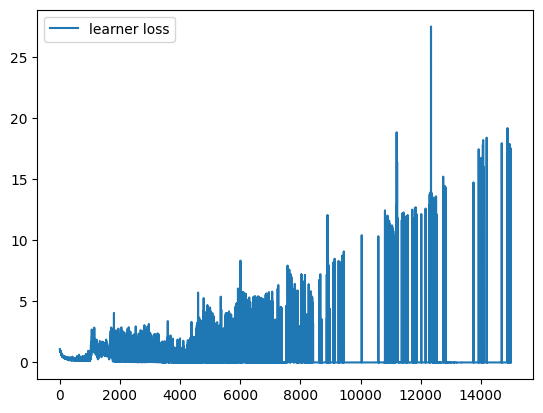

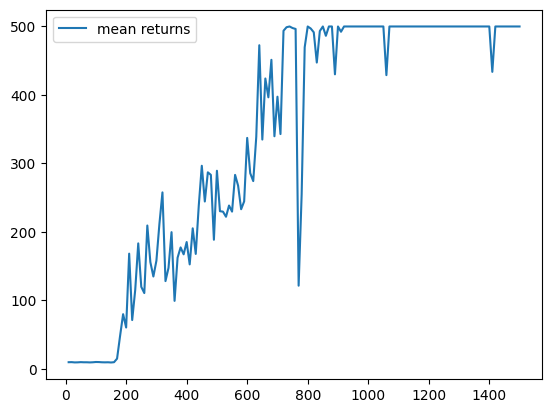

In [12]:
# training
steps = 1500
chunk_size = 1280
batch_size = 128
epsilon=0.2
losses = []

eval_freq = 10
mean_returns = []
eval_steps = []

best_params = learner_params
best_mean_ret = 0
replay_buffer = ReplayBuffer(5_000)

for step in range(1, steps + 1):
    obs = collect_transitions(obs,
                              learner_params,
                              replay_buffer,
                              epsilon=epsilon)

    chunk = replay_buffer.sample(min(len(replay_buffer), chunk_size))
    for idx in range(0, len(chunk), batch_size):
        batch = chunk[idx:idx + batch_size]
        learner_params, opt_state, loss = update_learner(learner_params,
                                                         target_params,
                                                         opt_state,
                                                         batch)
        losses.append(loss)
    
    target_params = update_target(learner_params, target_params)

    if step % eval_freq == 0:
        eval_steps.append(step)
        mean_ret = evaluate(learner_params, seed=step)
        mean_returns.append(mean_ret)
        if mean_ret > best_mean_ret:
            best_mean_ret = mean_ret
            best_params = learner_params
        print(f'step: {step}, mean return: {mean_ret}')

loss_steps = np.arange(1, len(losses) + 1)

plt.figure()
plt.plot(loss_steps, losses, label='learner loss')
plt.legend()

plt.figure()
plt.plot(eval_steps, mean_returns, label='mean returns')
plt.legend()

ckpt = dict(best_params=best_params,
            latest_learner_params=learner_params,
            latest_target_params=target_params,
            opt_state=opt_state)

ckpt_path = os.path.join('checkpoints', 'latest_ckpt.pkl')
with open(ckpt_path, 'wb') as f:
    pickle.dump(ckpt, f)

venv.close()

In [13]:
# generate video
with open(ckpt_path, 'rb') as f:
    ckpt = pickle.load(f)
params = ckpt['best_params']

test_env = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=500)
test_env = wrappers.RecordVideo(env=test_env, 
                                video_folder='./video',
                                name_prefix='DQN',
                                disable_logger=True)

obs, info = test_env.reset(seed=42)
terminated, truncated = False, False
while not terminated and not truncated:
    act = greedy_pol(params, obs[None])
    obs, rew, terminated, truncated, info = test_env.step(np.asarray(act[0]))
test_env.close()

/Users/xgu3km/Documents/Personal/Reinforcement Learning/RL Algorithms/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/xgu3km/Documents/Personal/Reinforcement Learning/RL Algorithms/DQN/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
